In [421]:
import wfdb
import mne
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer

record_path = "Desktop/PSG data/slp01a"

record = wfdb.rdrecord(record_path)
annotation = wfdb.rdann(record_path, 'st')

annotation_mne = mne.Annotations(
    onset=annotation.sample / record.fs,
    duration=30,
    description=annotation.aux_note
)

signals = record.p_signal  # Signal data as NumPy array
sampling_rate = record.fs  # Sampling frequency (e.g., 250 Hz)
channel_names = record.sig_name  # Channel names

# Define channel types (all 'misc' by default; adjust based on signal type)
channel_types = ["eeg" if "EEG" in ch else "misc" for ch in channel_names]

# Create MNE Info object
info = mne.create_info(
    ch_names=channel_names,
    sfreq=sampling_rate,
    ch_types=channel_types
)

# Convert signals to MNE RawArray
raw = mne.io.RawArray(signals.T, info)

# Add annotations to the raw object
raw.set_annotations(annotation_mne)
#Set chhannel types to correct
raw.set_channel_types({"ECG":"ecg","Resp (sum)": "resp","BP":"misc"})

Creating RawArray with float64 data, n_channels=4, n_times=1800000
    Range : 0 ... 1799999 =      0.000 ...  7199.996 secs
Ready.


C:\Users\piotr\AppData\Local\Temp\ipykernel_11428\771619307.py:41: RuntimeWarning: The unit for channel(s) ECG, Resp (sum) has changed from NA to V.
  raw.set_channel_types({"ECG":"ecg","Resp (sum)": "resp","BP":"misc"})


<RawArray | 4 x 1800000 (7200.0 s), ~54.9 MiB, data loaded>

In [423]:
# Reclassify events
new_id = {}
for desc in raw.annotations.description:
    if "H" in desc or "HA" in desc:  # Hypopnea
        new_id[desc] = 1
    elif " A " in desc or "X" in desc:  # Obstructive Apnea
        new_id[desc] = 2
    elif "CA" in desc or "CAA" in desc:  # Central Apnea
        new_id[desc] = 3
    else:  # Other
        new_id[desc] = 4

# Generate events with the new mapping
events, event_id = mne.events_from_annotations(raw, event_id=new_id)

new_annotations = mne.Annotations(
    onset=events[:, 0] / raw.info["sfreq"],  # Convert sample index to seconds
    duration=[30] * len(events),  # Assume each event lasts 30 seconds
    description=[e for e in events[:, 2]]  # Convert IDs back to labels
)

# Set the new annotations in raw
raw.set_annotations(None)
raw.set_annotations(new_annotations)
raw_copy=raw.copy()
raw_train,raw_test=raw.crop(tmin=0,tmax=5999),raw_copy.crop(tmin=6000,tmax=7000)
events_train, event_id_train = mne.events_from_annotations(raw_train,event_id={"1":1,"2":2,"3":3,"4":4})
events_test, event_id_test = mne.events_from_annotations(raw_test,event_id={"1":1,"2":2,"3":3,"4":4})

Used Annotations descriptions: ['1 LA', '2', '2 H', '2 H H', '2 H LA', '2 HA', '2 L', '2 L HA', '2 L LA', '2 LA', '2 LA H', '2 LA HA', '2 LA L', '2 LA LA', '3', '3 H', '3 H LA', '3 HA', '3 L', '3 L HA LA', '3 L L', '3 L LA', '3 LA', '3 LA L', '3 LA LA', '4', '4 L', '4 L L', '4 L L L', '4 L LA', '4 LA', '4 LA HA LA', '4 LA L', '4 LA LA', 'MT', 'R', 'R H', 'R HA', 'W', 'W HA', 'W LA']
Used Annotations descriptions: ['1', '4']
Used Annotations descriptions: ['1', '4']


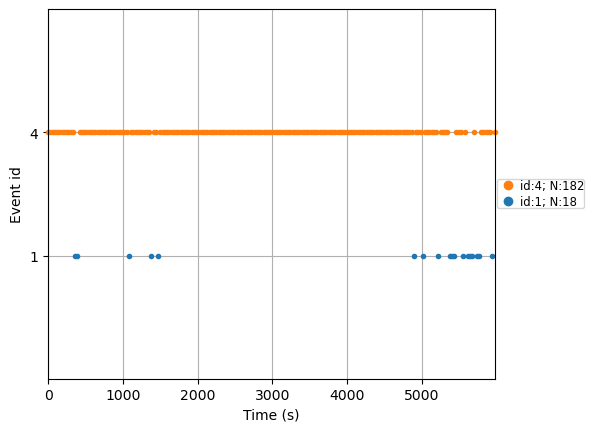

In [425]:
import matplotlib.pyplot as plt
# Plot the events
fig = mne.viz.plot_events(
    events_train,
    sfreq=raw.info["sfreq"],  # Sampling frequency of the raw data
    first_samp=raw.first_samp,  # First sample index of the raw data
)

# Extract color cycle for event colors
stage_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

plt.show()

In [377]:
# making sure annotations correspond to "something".
for i in events_train[:100]:
    if i[-1]!=4:
        raw.plot(start=i[0]/250-15,duration=60,color="k",
            picks=["ECG","BP",'Resp (sum)',"EEG (C4-A1)"],
            scalings=dict(eeg=0.2,  ecg=0.7, resp=1,misc=50),
            title="PSG Data Excluding BP")

C:\Users\piotr\anaconda_projects\anaconda3\Lib\site-packages\mne\viz\_figure.py:379: RuntimeWarning: Mean of empty slice
  data -= np.nanmean(data, axis=1, keepdims=True)


ValueError: zero-size array to reduction operation maximum which has no identity

In [427]:
tmax = 30.0 - 1.0 / raw.info["sfreq"]  # tmax in included
epochs_train = mne.Epochs(
    raw_train,
    events=events_train,
    tmin=0.0,
    tmax=tmax,
    baseline=None,
)
epochs_test=mne.Epochs(
    raw_test,
    events=events_test,
    tmin=0.0,
    tmax=tmax,
    baseline=None,
)

Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated


RuntimeError: Event time samples were not unique. Consider setting the `event_repeated` parameter."

In [413]:
print(epochs_test["1"])

<Epochs | 37 events (good & bad), 0 – 29.996 s (baseline off), ~8 KiB, data not loaded,
 '1': 37>


Using data from preloaded Raw for 37 events and 7500 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...
Using data from preloaded Raw for 203 events and 7500 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).
Averaging across epochs before plotting...


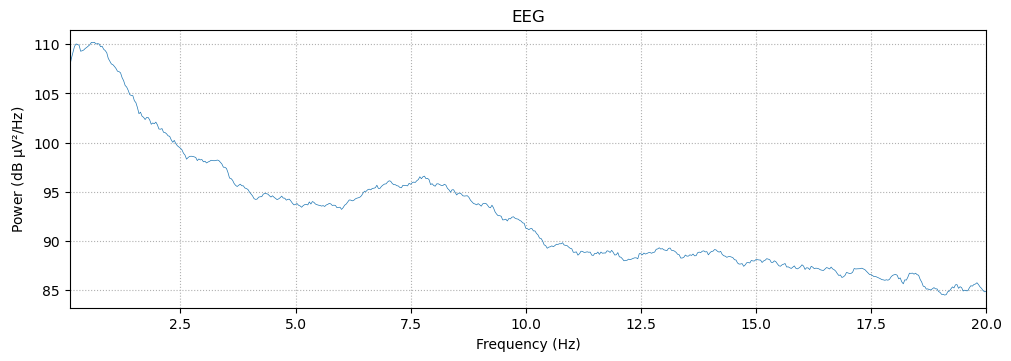

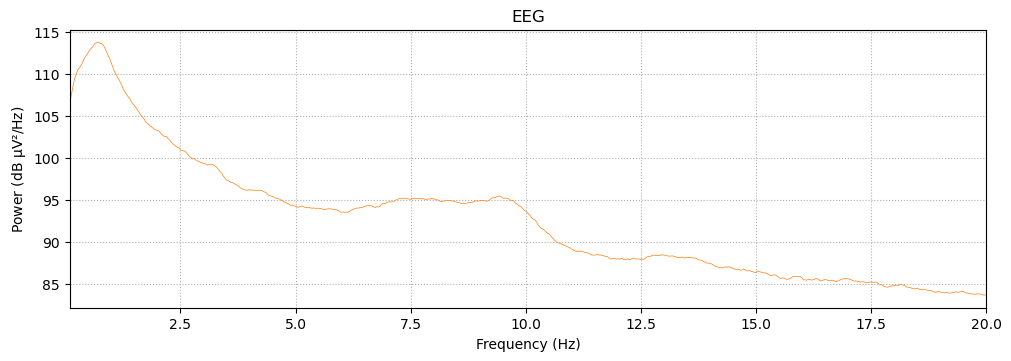

In [309]:
for eve,color in zip(["1","4"],stage_colors):
    spectrum=epochs[eve].compute_psd(fmin=0.1,fmax=20.0,picks=['ECG', 'BP', 'EEG (C4-A1)', 'Resp (sum)'])
    spectrum.plot(ci=None,
            color=color,
            show=False,
            average=True,
            amplitude=False,
            spatial_colors=False,
        )
plt.show()

In [311]:
def power_band(epochs):
    # specific frequency bands
    FREQ_BANDS = {
        "delta": [0.5, 4.5],
        "theta": [4.5, 8.5],
        "alpha": [8.5, 11.5],
        "sigma": [11.5, 15.5],
        "beta": [15.5, 30],
    }

    spectrum = epochs.compute_psd(picks=['ECG', 'BP', 'EEG (C4-A1)', 'Resp (sum)'], fmin=0.5, fmax=30.0)
    psds, freqs = spectrum.get_data(return_freqs=True)
    # Normalize the PSDs
    psds /= np.sum(psds, axis=-1, keepdims=True)

    X = []
    for fmin, fmax in FREQ_BANDS.values():
        psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
        X.append(psds_band.reshape(len(psds), -1))

    return np.concatenate(X, axis=1)

In [313]:
pipe = make_pipeline(
    FunctionTransformer(power_band, validate=False),
    RandomForestClassifier(n_estimators=100, random_state=42),
)

# Train
y_train = epochs.events[:, 2]
pipe.fit(epochs, y_train)

# # Test
# y_pred = pipe.predict(epochs_test)

# # Assess the results
# y_test = epochs_test.events[:, 2]
# acc = accuracy_score(y_test, y_pred)

# print(f"Accuracy score: {acc}")

Using data from preloaded Raw for 240 events and 7500 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows


Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function power_band at 0x00000209E0F32020>)),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

In [317]:
print(epochs.events)

[[      1       0       4]
 [   7500       0       4]
 [  15000       0       4]
 [  22500       0       4]
 [  30000       0       4]
 [  37500       0       4]
 [  45000       0       4]
 [  52500       0       4]
 [  60000       0       4]
 [  67500       0       4]
 [  75000       0       4]
 [  82500       0       4]
 [  90000       0       1]
 [  97500       0       1]
 [ 105000       0       4]
 [ 112500       0       4]
 [ 120000       0       4]
 [ 127500       0       4]
 [ 135000       0       4]
 [ 142500       0       4]
 [ 150000       0       4]
 [ 157500       0       4]
 [ 165000       0       4]
 [ 172500       0       4]
 [ 180000       0       4]
 [ 187500       0       4]
 [ 195000       0       4]
 [ 202500       0       4]
 [ 210000       0       4]
 [ 217500       0       4]
 [ 225000       0       4]
 [ 232500       0       4]
 [ 240000       0       4]
 [ 247500       0       4]
 [ 255000       0       4]
 [ 262500       0       4]
 [ 270000       0       1]
 